## Download repo


In [0]:
import os
import shutil
import zipfile
import urllib.request

In [0]:
REPO_ZIP_FILE = 'LinearizedNNs-master.zip'
urllib.request.urlretrieve('https://github.com/maxkvant/LinearizedNNs/archive/master.zip', REPO_ZIP_FILE)

REPO_PATH = "LinearizedNNs-master"
if os.path.exists(REPO_PATH):
    shutil.rmtree(REPO_PATH)
    
with zipfile.ZipFile(REPO_ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall('.')
    
assert os.path.exists(REPO_PATH)

## Imports

In [0]:
import sys
sys.path.append(f"{REPO_PATH}/src")

In [4]:
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST

from xgboost import XGBClassifier

from pytorch_impl.estimators import SgdEstimator
from pytorch_impl.nns import warm_up_batch_norm
from pytorch_impl import ClassifierTraining
from pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from pytorch_impl.nns.utils import to_one_hot
from from_neural_kernels import to_zca, CustomTensorDataset

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def Conv(in_filters, out_filters):
    conv = nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1, bias=False)
    conv.weight.data *= np.sqrt(3)
    return conv  

def BatchNorm(num_filters):
    return nn.BatchNorm2d(num_filters) 

class Normalize(nn.Module):
    def forward(self, input):
        return nn.functional.normalize(input, p=2, dim=1, eps=1e-8)  

class Myrtle10(nn.Module):
    def __init__(self, num_classes=10, input_filters=3, num_filters=256):
        super(Myrtle10, self).__init__()

        self.layers = nn.Sequential(
            Conv(input_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),

            Conv(num_filters, num_filters),   BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters),   BatchNorm(num_filters), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            nn.AvgPool2d(kernel_size=8, stride=8),
            Normalize(),
            Flatten()
        )
        self.classifier =  nn.Linear(num_filters, num_classes, bias=True)
        # self.classifier.weight.data *= np.sqrt(3)
        
        self.to_readout = nn.Linear(num_filters, num_filters, bias=False)
        # self.to_readout.weight.data *= np.sqrt(3)

    def readout(self, x):
        return self.layers(x)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

## Cifar10

In [0]:
def get_cifar_zca():
  trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
  testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

  X_train = np.asarray(trainset.data).astype(np.float64)
  y_train = np.asarray(trainset.targets)
  X_test  = np.asarray(testset.data).astype(np.float64)
  y_test  = np.asarray(testset.targets)

  (X_train, X_test), global_ZCA = to_zca(X_train, X_test)

  X_train = np.transpose(X_train, (0,3,1,2))
  X_test  = np.transpose(X_test,  (0,3,1,2))

  return X_train, y_train, X_test, y_test

In [11]:
%%time

X_train, y_train, X_test, y_test = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 1min 57s, sys: 8.99 s, total: 2min 6s
Wall time: 1min 6s


In [12]:
torch.manual_seed(0)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

cifar_train = CustomTensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long), transform='all')
cifar_test  = CustomTensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long), transform=None)

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(cifar_test,  batch_size=128, shuffle=True)

device

device(type='cuda', index=0)

0.021946065

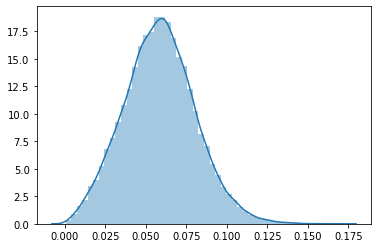

In [13]:
model = Myrtle10().to(device)
for batch_id, (X, y) in enumerate(train_loader):
  if batch_id > 20:
    break
  X, y = X.to(device), y.to(device)
  model.readout(X)

_, (X, y) = next(enumerate(train_loader))
X, y = X.to(device), y.to(device)


output = model.readout(X).detach().cpu().numpy()
sns.distplot(output.reshape(-1))

np.std(output.reshape(-1))

In [15]:
from pytorch_impl.nns.utils import print_sizes

print_sizes(Myrtle10(num_filters=64).to(device))

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
torch.Size([64, 64])
302538


302538

epoch 0/30, 0s since start


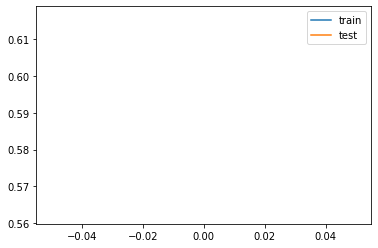

epoch 1/30, 58s since start


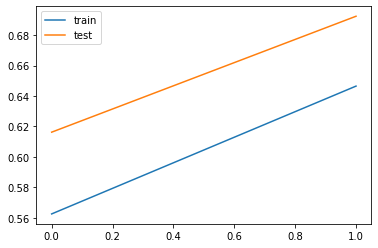

epoch 2/30, 116s since start


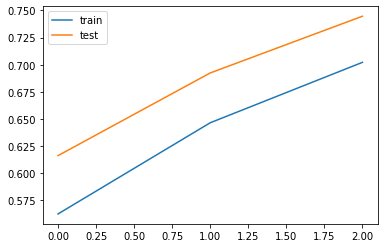

epoch 3/30, 174s since start


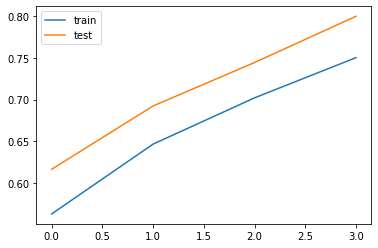

epoch 4/30, 231s since start


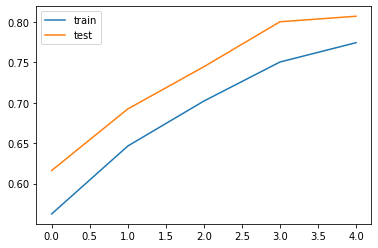

epoch 5/30, 289s since start


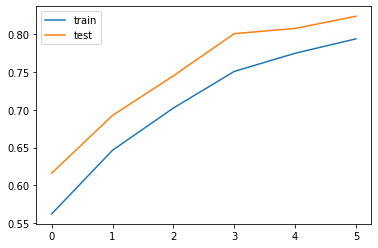

epoch 6/30, 347s since start


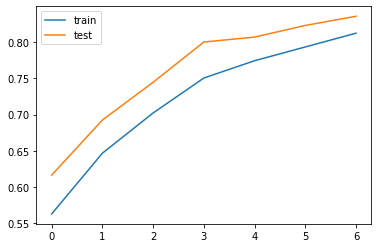

epoch 7/30, 405s since start


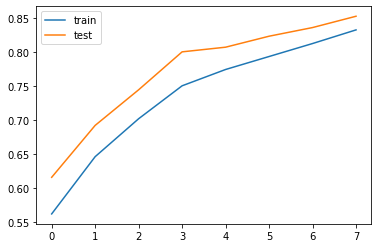

epoch 8/30, 463s since start


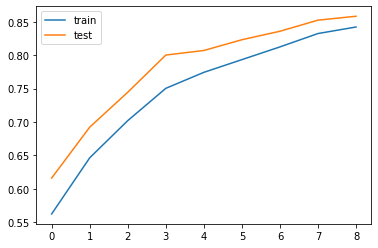

epoch 9/30, 521s since start


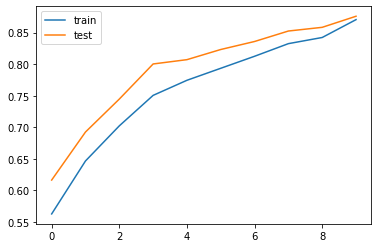

epoch 10/30, 579s since start


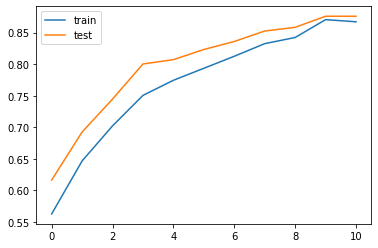

epoch 11/30, 637s since start


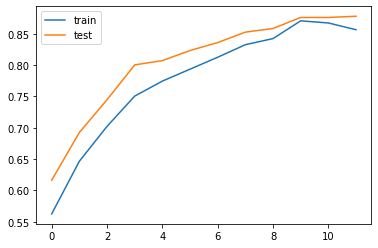

epoch 12/30, 695s since start


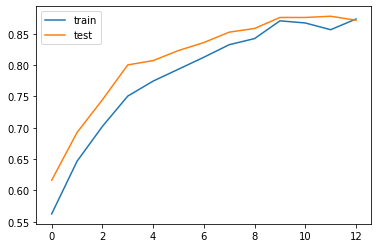

epoch 13/30, 753s since start


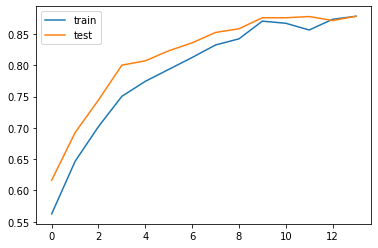

epoch 14/30, 811s since start


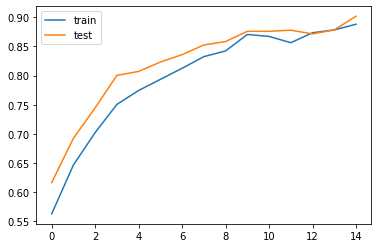

epoch 15/30, 869s since start


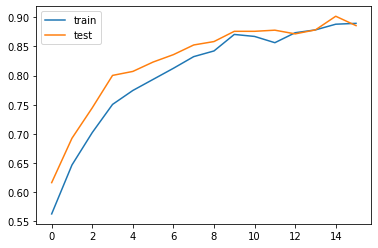

epoch 16/30, 927s since start


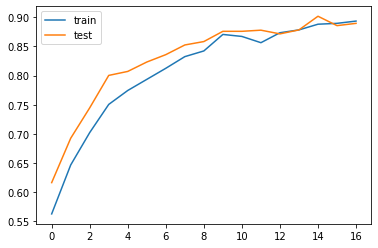

epoch 17/30, 985s since start


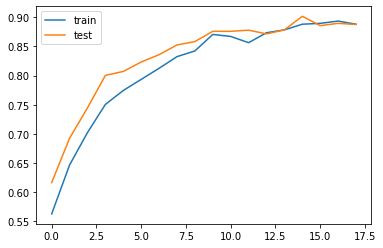

epoch 18/30, 1043s since start


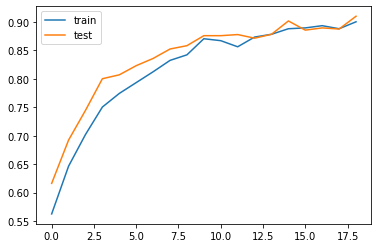

epoch 19/30, 1101s since start


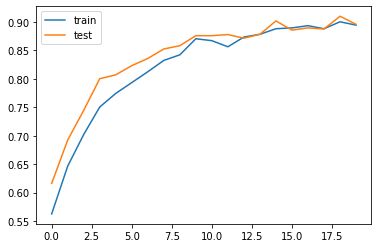

epoch 20/30, 1159s since start


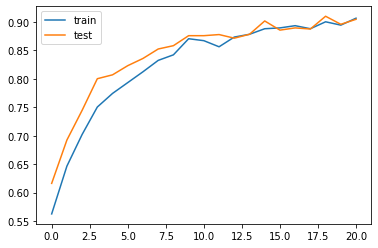

epoch 21/30, 1217s since start


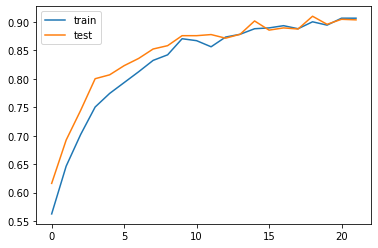

epoch 22/30, 1275s since start


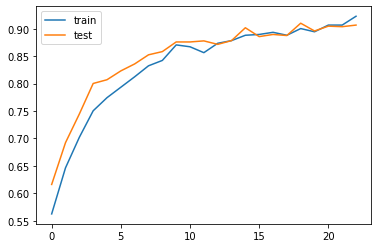

epoch 23/30, 1333s since start


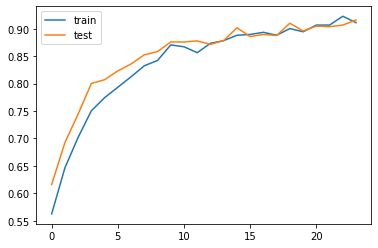

epoch 24/30, 1391s since start


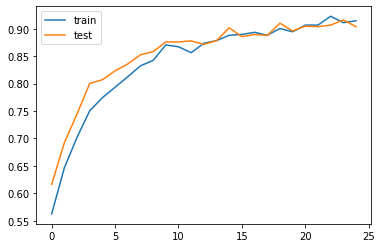

epoch 25/30, 1449s since start


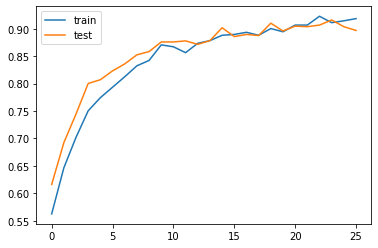

epoch 26/30, 1506s since start


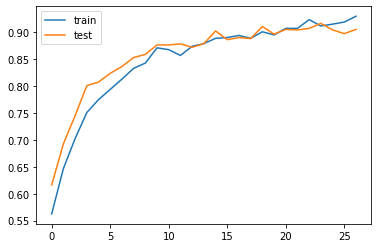

epoch 27/30, 1564s since start


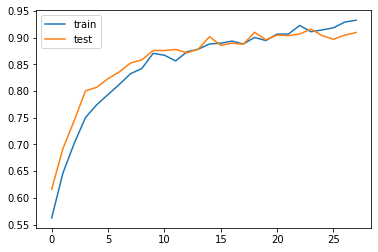

epoch 28/30, 1622s since start


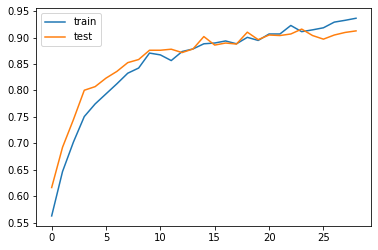

epoch 29/30, 1680s since start


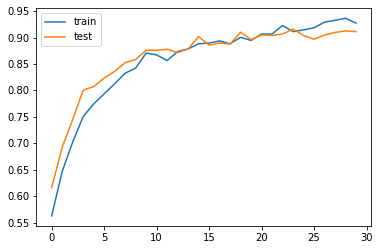

training took 1738s
test_accuracy 0.911


In [12]:
model = Myrtle10(num_filters=256).to(device)

learning_rate = 0.07

estimator = SgdEstimator(model, nn.CrossEntropyLoss(), learning_rate)
training  = ClassifierTraining(estimator, device)

training.train(train_loader, test_loader, num_epochs=30, learning_rate=learning_rate)

epoch 0/20, 0s since start


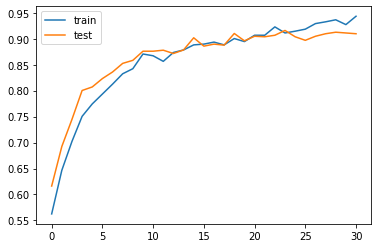

epoch 1/20, 58s since start


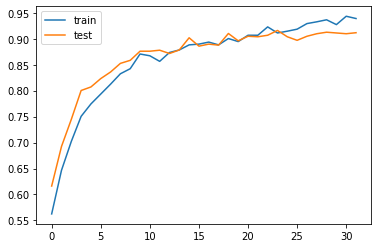

epoch 2/20, 116s since start


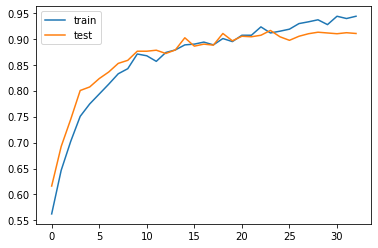

epoch 3/20, 174s since start


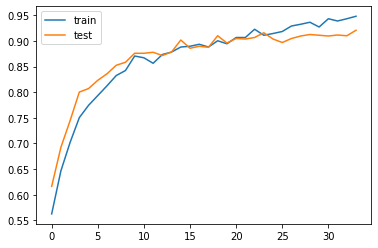

epoch 4/20, 232s since start


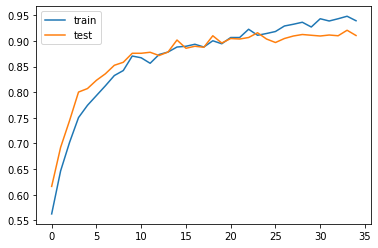

epoch 5/20, 290s since start


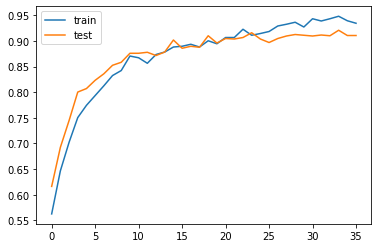

epoch 6/20, 348s since start


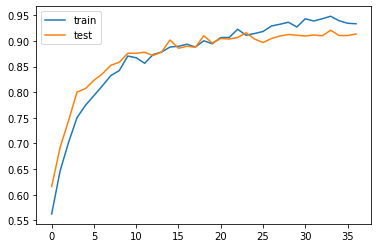

epoch 7/20, 406s since start


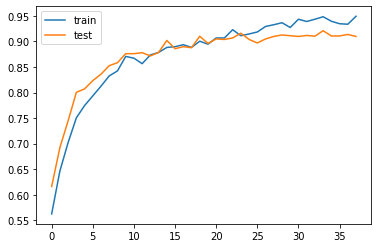

epoch 8/20, 463s since start


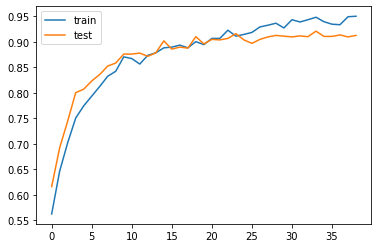

epoch 9/20, 521s since start


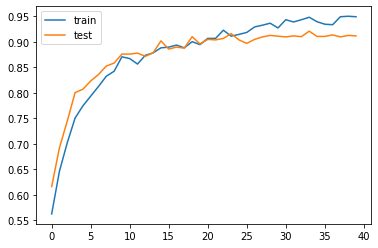

epoch 10/20, 579s since start


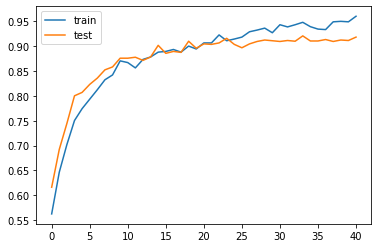

epoch 11/20, 637s since start


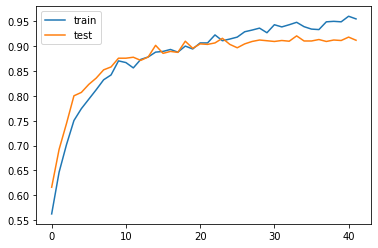

epoch 12/20, 695s since start


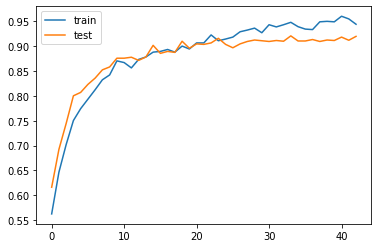

epoch 13/20, 753s since start


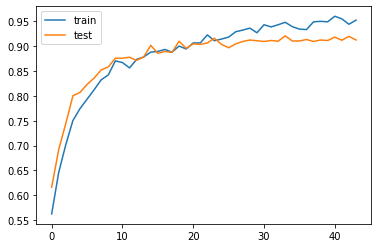

epoch 14/20, 811s since start


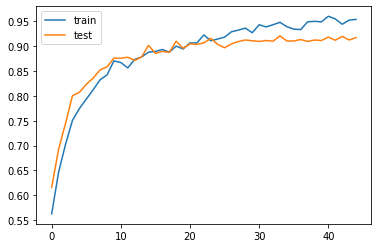

epoch 15/20, 869s since start


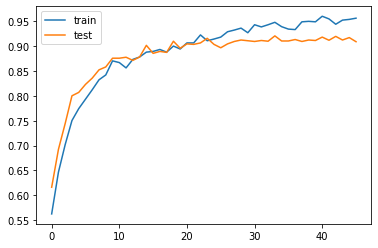

epoch 16/20, 927s since start


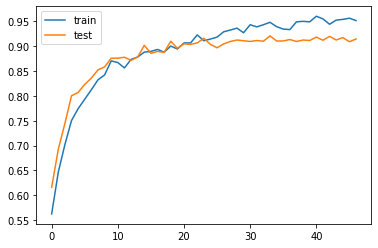

epoch 17/20, 985s since start


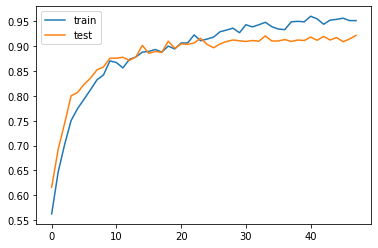

epoch 18/20, 1042s since start


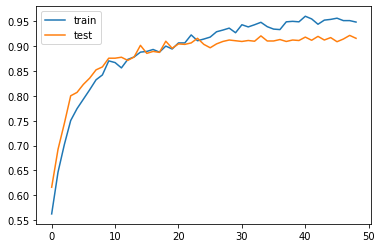

epoch 19/20, 1100s since start


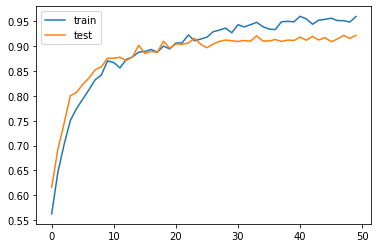

training took 1158s
test_accuracy 0.918


In [13]:
training.train(train_loader, test_loader, num_epochs=20, learning_rate=learning_rate)

In [15]:
ClassifierTraining(estimator, device).get_accuracy(test_loader)

0.921875

In [19]:
X_train, y_train, X_test, y_test = get_cifar_zca()

cifar_train = CustomTensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long), transform=None)
cifar_test  = CustomTensorDataset(torch.tensor(X_test),  torch.tensor(y_test, dtype=torch.long),  transform=None)

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1280, shuffle=True)
test_loader  = torch.utils.data.DataLoader(cifar_test,  batch_size=1280, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
torch.manual_seed(0)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
device

device(type='cuda', index=0)

In [0]:
def to_features(models, X):
  readouts = [model.readout(X).detach() for model in models]
  features = torch.cat(readouts, 1)
  _, m = features.size()

  return features / np.sqrt(m) * np.sqrt(1. / 0.0156249953)

In [0]:
import time

def compute_kernels(models, X_train, X_test, device):
  with torch.no_grad():
    X_train = X_train.to(device)
    X_test  = X_test.to(device)
    
    
    n_train = len(X_train)
    n_test  = len(X_test)

    train_kernel = torch.zeros([n_train, n_train]).to(device)
    test_kernel  = torch.zeros([n_test,  n_train]).to(device)

    scale = np.sqrt(1. / 0.0156249953)

    m = 0
    start_time = time.time()
    for model_i, model in enumerate(models):
      if model_i  % 100 == 0:
        print(f"{model_i} models done. time {time.time() - start_time:.0f}s")
      train_features = scale * model.readout(X_train) 
      test_features  = scale * model.readout(X_test)

      m += train_features.size()[1]

      train_kernel += torch.matmul(train_features, train_features.T)
      test_kernel  += torch.matmul(test_features,  train_features.T)
    
    train_kernel /= m
    test_kernel  /= m
    
    return train_kernel, test_kernel

In [0]:
_, (X_train, labels_train) = next(enumerate(train_loader))
_, (X_test,  labels_test)  = next(enumerate(test_loader))

In [0]:
n_models = 5000

models = (Myrtle10(num_filters=64).to(device) for _ in range(n_models))

In [30]:
%%time

from pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from pytorch_impl.nns.utils import to_one_hot

num_classes = 10

y_train = to_one_hot(labels_train, num_classes).to(device)
y_test  = to_one_hot(labels_test,  num_classes).to(device)

train_kernel, test_kernel = compute_kernels(models, X_train, X_test, device)

0 models done. time 0s
100 models done. time 20s
200 models done. time 39s
300 models done. time 59s
400 models done. time 79s
500 models done. time 100s
600 models done. time 120s
700 models done. time 140s
800 models done. time 160s
900 models done. time 180s
1000 models done. time 200s
1100 models done. time 220s
1200 models done. time 240s
1300 models done. time 260s
1400 models done. time 281s
1500 models done. time 301s
1600 models done. time 321s
1700 models done. time 341s
1800 models done. time 361s
1900 models done. time 381s
2000 models done. time 401s
2100 models done. time 421s
2200 models done. time 442s
2300 models done. time 462s
2400 models done. time 482s
2500 models done. time 502s
2600 models done. time 522s
2700 models done. time 542s
2800 models done. time 562s
2900 models done. time 582s
3000 models done. time 603s
3100 models done. time 623s
3200 models done. time 643s
3300 models done. time 663s
3400 models done. time 683s
3500 models done. time 703s
3600 model

In [31]:
train_kernel[:5,:5]

tensor([[1.0000, 0.9178, 0.9422, 0.9506, 0.8806],
        [0.9178, 1.0000, 0.8750, 0.9214, 0.9488],
        [0.9422, 0.8750, 1.0000, 0.9535, 0.8134],
        [0.9506, 0.9214, 0.9535, 1.0000, 0.8797],
        [0.8806, 0.9488, 0.8134, 0.8797, 1.0000]], device='cuda:0')

In [32]:
test_kernel[:5,:5]

tensor([[0.9089, 0.9562, 0.8546, 0.9139, 0.9603],
        [0.8998, 0.9457, 0.8488, 0.8997, 0.9477],
        [0.9202, 0.8470, 0.9567, 0.9342, 0.7729],
        [0.8961, 0.9472, 0.8370, 0.9037, 0.9583],
        [0.9357, 0.9457, 0.9174, 0.9569, 0.9186]], device='cuda:0')

In [44]:
lr = 1e5

n = len(train_kernel)

exp_term = - lr * compute_exp_term(- lr * train_kernel, device)
y_pred = torch.matmul(test_kernel, torch.matmul(exp_term, - y_train))
(y_pred.argmax(dim=1) == labels_test.to(device)).float().mean()

tensor(0.5836, device='cuda:0')

In [34]:
"""
TODO experiments:
1. ZCA ✔️
2. random features ✔️
"""

'\nTODO experiments:\n1. ZCA ✔️\n2. random features ✔️\n'